In [94]:
%matplotlib inline
import sklearn
import codecs, os, sys, json, string
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from sklearn import preprocessing
# import sympy
# from sympy import symbols, integrate
from sympy import *

In [35]:
def join_path(d, file):
    return os.path.join(d, file)

In [36]:
data_path = "..\\data\\extracted\\"
bhot100 = pd.read_csv(join_path(data_path, 'hot-100.csv'))
bhot100['title'] = bhot100.apply(lambda row: row['title'].lower().strip(), axis=1)
bhot100['artist_name'] = bhot100.apply(lambda row: row['artist_name'].lower().strip(), axis=1)
grammy = pd.read_csv(join_path(data_path, 'grammy.csv'), 
                     dtype={'award_for': 'str',
                            'name': 'str'
                        })
grammy['award_for'] = grammy.apply(lambda row: str(row['award_for']).lower().strip(), axis=1)
grammy['name'] = grammy.apply(lambda row: str(row['name']).lower().strip(), axis=1)
grammy = grammy[grammy['award_type']=='Individual']
ama = pd.read_csv(join_path(data_path, 'ama.csv'), 
                    dtype={'award_for': 'str',
                            'name': 'str'
                    })
ama['award_for'] = ama.apply(lambda row: str(row['award_for']).lower().strip(), axis=1)
ama['name'] = ama.apply(lambda row: str(row['name']).lower().strip(), axis=1)

msd = pd.read_csv(join_path(data_path, 'MSDSet.csv'))
msd['artist_name'] = msd.apply(lambda row: str(row['artist_name']).lower().strip(), axis=1)
msd['title'] = msd.apply(lambda row: str(row['title']).lower().strip(), axis=1)


In [67]:
spotify = pd.read_csv(join_path(data_path, 'spotify2.csv'))
spotify['title'] = spotify.apply(lambda row: str(row['title']).lower().strip(), axis=1)
spotify['artist_name'] = spotify.apply(lambda row:str(row['artist_name']).lower().strip(), axis=1)

In [37]:
titles = bhot100.title
merge_song_bhot100 = bhot100[['title', 'artist_name', 'current_rank']].groupby(['title', 'artist_name']).sum()
count_onchart_bhot100 = bhot100[['title', 'artist_name', 'current_rank']].groupby(['title', 'artist_name'])\
                        .count().rename(columns={"current_rank": "onchart_count"})
bhot100_song_num = len(merge_song_bhot100)

# count_onchart_bhot100 = count_onchart_bhot100.sort_values('onchart_count', ascending=False)
# count_onchart_bhot100
avr_bhot100_ranks = merge_song_bhot100.current_rank / count_onchart_bhot100.onchart_count
avr_bhot100_ranks.sort_values()
# avr_bhot100_ranks['Radioactive']


title                                            artist_name                                
zeze                                             kodak black featuring travis scott & offset      4.666667
in my feelings                                   drake                                            5.722222
sicko mode                                       travis scott                                     6.307692
girls like you                                   maroon 5 featuring cardi b                       6.478261
get back                                         the beatles with billy preston                   6.833333
mrs. brown you've got a lovely daughter          herman's hermits                                 7.000000
i want to hold your hand                         the beatles                                      7.533333
hey jude                                         the beatles                                      7.842105
i like it                                        ca

In [38]:
overall_avr_bhot_rank = np.mean(avr_bhot100_ranks)
print (overall_avr_bhot_rank)
blamda = 1/overall_avr_bhot_rank
print (blamda)

61.82629783506455
0.016174347082332556


In [39]:
def rank_prob(rank):
    x = symbols('x')
    return integrate(blamda * exp(blamda*(x-100)), (x, rank-1, rank))
#     return blamda*np.exp(blamda*(rank-100))

In [40]:
rank_prob(1)/rank_prob(2)

0.983955755284751

In [41]:
rank_prob(1)/rank_prob(10)

0.864530128451833

In [42]:
rank_prob(1)/rank_prob(25)

0.678287303057853

In [43]:
rank_prob(1)/rank_prob(50)

0.452692131013324

In [44]:
rank_prob(1)/rank_prob(100)

0.201642215756864

In [45]:
rank_prob(1)/rank_prob(101)

0.198407018702331

In [46]:
rank_prob(1)

0.00323519705453182

In [49]:
rank_prob_table_bhot100 = [float(rank_prob(i)) for i in range(1, 101)]
rankprobsum = np.sum(rank_prob_table_bhot100)
rankprobsum

0.8015929812976694

In [50]:
out_chart_prob = 1-rankprobsum
rank_prob_table_bhot100.append(out_chart_prob)
rank_prob_table_bhot100

[0.0032351970545318187,
 0.003287949724523509,
 0.0033415625721626985,
 0.003396049623385494,
 0.003451425132833086,
 0.003507703587580846,
 0.0035648997109283265,
 0.003623028466251288,
 0.00368210506091593,
 0.003742144950257875,
 0.0038031638416251845,
 0.0038651776984877095,
 0.003928202744613446,
 0.003992255468312944,
 0.004057352626752664,
 0.004123511250339329,
 0.004190748647174669,
 0.004259082407584547,
 0.0043285304087195,
 0.004399110819232832,
 0.004470842104033257,
 0.004543743029115643,
 0.0046178326664707,
 0.004693130399074097,
 0.004769655925957794,
 0.004847429267363312,
 0.004926470769979485,
 0.005006801112265313,
 0.00508844130985997,
 0.0051714127210806815,
 0.005255737052510201,
 0.005341436364676155,
 0.005428533077821596,
 0.00551704997777136,
 0.005607010221892361,
 0.005698437345152629,
 0.005791355266277831,
 0.005885788294009209,
 0.005981761133462715,
 0.006079298892592733,
 0.006178427088760208,
 0.006279171655408811,
 0.006381558948849009,
 0.006485615

In [ ]:
# f_score_table_bhot100 = -np.log(rank_prob_table_bhot100)
# f_score_table_bhot100
# f_norm_score_table_bhot100 = preprocessing.MinMaxScaler()\
#         .fit_transform(np.array(f_score_table_bhot100).reshape(-1, 1))
# f_norm_score_table_bhot100 = f_norm_score_table_bhot100.reshape(-1).tolist()
# f_norm_score_table_bhot100

In [51]:
score_table_bhot100 = [1/i for i in rank_prob_table_bhot100]
score_table_bhot100

[309.10018250641457,
 304.14090353675357,
 299.26119245248435,
 294.4597726469934,
 289.73538799584355,
 285.086802528166,
 280.51280010331413,
 276.01218409268813,
 271.5837770667109,
 267.22642048675556,
 262.93897440207985,
 258.7203171515918,
 254.56934507040185,
 250.48497220108567,
 246.46613000959653,
 242.5117671056939,
 238.62084896792436,
 234.79235767291246,
 231.0252916291347,
 227.31866531482186,
 223.6715090201632,
 220.0828685936123,
 216.55180519225618,
 213.07739503621912,
 209.65872916696608,
 206.29491320951965,
 202.98506713847084,
 199.72832504775744,
 196.52383492412125,
 193.37075842421407,
 190.26827065528104,
 187.2155599593348,
 184.21182770084323,
 181.2562880577629,
 178.34816781598462,
 175.48670616702475,
 172.67115450900513,
 169.90077625079383,
 167.17484661931346,
 164.49265246991575,
 161.8534920998258,
 159.25667506455423,
 156.70152199727968,
 154.18736443110066,
 151.71354462416502,
 149.27941538759438,
 146.88433991616418,
 144.52769162170975,
 142

In [52]:
norm_score_table_bhot100 = preprocessing.MinMaxScaler((1, 100))\
        .fit_transform(np.array(score_table_bhot100).reshape(-1, 1))
norm_score_table_bhot100 = (norm_score_table_bhot100).reshape(-1).tolist()
norm_score_table_bhot100

[99.99999999999999,
 98.38529054703532,
 96.79648788767526,
 95.23317636698701,
 93.69494699890325,
 92.1813973592293,
 90.69213148036376,
 89.22675974770266,
 87.7848987977208,
 86.36617141766527,
 84.97020644687932,
 83.59663867969914,
 82.24510876990905,
 80.91526313673064,
 79.60675387232557,
 78.31923865076892,
 77.05238063850477,
 75.80584840620506,
 74.579315842088,
 73.37246206658087,
 72.1849713483833,
 71.01653302186605,
 69.86684140579288,
 68.73559572335593,
 67.62250002348085,
 66.52726310340628,
 65.44959843249835,
 64.38922407729197,
 63.3458626277301,
 62.31924112459073,
 61.30909098807889,
 60.31514794755507,
 59.33715197240775,
 58.37484720401522,
 57.42798188881836,
 56.496308312450225,
 55.579582734936416,
 54.677565326924515,
 53.79002010694495,
 52.916714879670145,
 52.05742117517317,
 51.21191418915273,
 50.37997272412523,
 49.56137913155115,
 48.755919254898316,
 47.96338237361516,
 47.183561148001296,
 46.416251564965535,
 45.66125288465183,
 44.91836758792438,

In [53]:
grammy_num = len(grammy)
grammy['cnt'] = grammy['year']
artist_grammy_count = grammy[['name', 'cnt']].groupby(['name']).count()
artist_grammy_count

,cnt
name,
'ikena,1
'round midnight,2
(everything i do) i do it for you (from robin hood - prince of thieves),1
(hey won't you play) another somebody done somebody wrong song,1
(i'm a) stand by my woman man,1
(i've had) the time of my life,1
(sittin' on) the dock of the bay,2
(there's) no gettin' over me,1
...again,1


In [54]:
# both grammy and billboard started from 1958
grammy_score = bhot100_song_num/grammy_num*100
grammy_score

912.5860373647985

In [55]:
#ama started from 1974
ama['cnt'] = ama['year']
ama_num = len(ama)
ama_score = bhot100_song_num/ama_num*100*(2018-1974)/(2018-1958)
ama_score

1982.3495145631068

In [57]:
def get_year_billboard_rank_score(rs):
    s = 0
    for r in rs:
        s += norm_score_table_bhot100[int(r-1)]
    s += (52 - len(rs))*norm_score_table_bhot100[100]
    return s

In [166]:
def get_scores(br, gr, ar, release_year):
    # order: from the year to now (which is 2018-1958)
    b_onchart_ranks = [[] for i in range(61)]
    for i in range(len(br)):
        on_chart_date_year = int(br.iloc[i]['chart_date'].split('-')[0])
        if on_chart_date_year >= 1958 and on_chart_date_year <= 2018:
            b_onchart_ranks[on_chart_date_year-1958].append(br.iloc[i]['current_rank'])
    
    grammy_wins = [0 for i in range(61)]
    for i in range(len(gr)):
        grammy_win_year = int(gr.iloc[i]['year'])
        grammy_win[grammy_win_year - 1958] = 1
    
    
    ama_wins = [0 for i in range(61)]
    for i in range(len(gr)):
        ama_win_year = int(ar.iloc[i]['year'])
        ama_win[ama_win_year - 1958] = 1
    
    final_scores = []
    for i in range(61):
        bill_year_score = get_year_billboard_rank_score(b_onchart_ranks[i])
        grammy_year_score = grammy_wins[i]*grammy_score/10
        ama_year_score = ama_wins[i]*ama_score/10
        final_scores.append(bill_year_score+grammy_year_score+ama_year_score)
    final_scores.reverse()
    return final_scores
    

In [171]:
def generate_feature():
    # from 01/04/1958 - 11/10/2018 22228 days which are 3175 weeks, 61 years
    mbhotd = merge_song_bhot100.reset_index()
    titles = mbhotd['title'].tolist()
    artists = mbhotd['artist_name'].tolist()
    feature_d = {'title':[],
                'artist_name':[],
                 'release_date':[],
                'spotify_popularity_2018':[]}
    for i in range(0, 61):
        feature_d['y_'+str(i)] = []
    
    for title, name in zip(titles, artists):
        bill_records = bhot100[(bhot100['title']==title) & (bhot100['artist_name']==name)]
        grammy_records = grammy[(grammy['award_for']==title) & (grammy['name']==name)]
        ama_records = ama[(ama['award_for']==title) & (ama['name']==name)]
        spotify_records = spotify[(spotify['title']==title) & (spotify['artist_name']==name)]
        
        
        
        if len(spotify_records) == 0:
#             print (title, name)
            continue
        
#         print (spotify_records)
#         print (np.argmax(spotify_records['spotify_score'].tolist()))
        sr_real = spotify_records.iloc[np.argmax(spotify_records['spotify_score'].tolist())]
        popularity_2018 = sr_real['spotify_score']
        datestr = str(sr_real['release_date'])

        if len(datestr) <= 4:
#             release_date = pd.to_datetime(datestr+'-1-1',format='%Y-%m-%d')
            release_date = datestr + '-1-1'
        elif len(datestr) == 6 or len(datestr) == 7:
#             release_date = pd.to_datetime(datestr+'-1',format='%Y-%m-%d')
            release_date = datestr + '-1'
        else:
            release_date = datestr
#             release_date = pd.to_datetime(datestr, format='%Y-%m-%d')
        release_year = int(release_date.split('-')[0])
        scores = get_scores(bill_records, grammy_records, ama_records, release_year)
        
        # put in feature dictionary
        feature_d['release_date'].append(release_date)
        feature_d['title'].append(title)
        feature_d['artist_name'].append(name)
        feature_d['spotify_popularity_2018'].append(popularity_2018)
        for i in range(0, 61):
            feature_d['y_'+str(i)].append(scores[i])
    feature_df = pd.DataFrame.from_dict(feature_d)
    feature_df.to_csv(join_path(data_path, 'features_strong.csv'))
        

In [172]:
import time
st = time.time()
generate_feature()
time.time()-st

2597.7069199085236

In [84]:
feature_df = pd.read_csv(join_path(data_path, 'features.csv'))
FEATURES = ['y_'+str(i) for i in range(0, 61)]
print (len(feature_df))

25326


In [86]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(feature_df[FEATURES], feature_df['spotify_popularity_2018'])
lr_coefs = lr.coef_
print ('Coefficients of Linear Regression: \n', lr_coefs)

Coefficients of Linear Regression: 
 [ 0.03956997  0.02442002  0.02137775  0.02154763  0.02063737  0.01872502
  0.01902984  0.01800889  0.01118261  0.01826658  0.0158763   0.01750166
  0.01805834  0.01686226  0.01572006  0.01628724  0.01563094  0.01244777
  0.01350211  0.01716678  0.01062532  0.00926389  0.01198285  0.01199193
  0.01258619  0.01466292  0.01150296  0.00876019  0.01079349  0.01257791
  0.01475569  0.01478439  0.0144467   0.01442818  0.01590204  0.01391318
  0.01060682  0.01220148  0.0099384   0.01365614  0.0135411   0.01107083
  0.01199657  0.00866109  0.00903188  0.00882748  0.01165807  0.00865886
  0.00472077  0.00392174  0.00442137  0.00414493  0.00303307  0.0022319
  0.00104998 -0.00371944 -0.00613672 -0.00689941 -0.00535008 -0.00453734
 -0.00670548]


<BarContainer object of 61 artists>

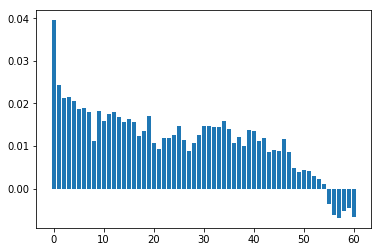

In [89]:
plt.bar(range(len(lr_coefs)), lr_coefs)

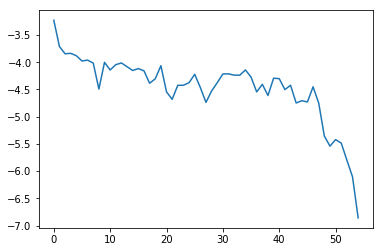

In [91]:
plt.plot(range(len(lr_coefs)), np.log(lr_coefs))

In [96]:
lr_popularity_pred = lr.predict(feature_df[FEATURES])
lr_popularity_truth = feature_df['spotify_popularity_2018']
lr_rmse = np.sqrt(sklearn.metrics.mean_squared_error(lr_popularity_pred, lr_popularity_truth))
print ("LR RMSE: {}".format(lr_rmse))

LR RMSE: 19.136723281044148


In [97]:
lr_popularity_truth

0        65
1        18
2        51
3        53
4        63
5        65
6        70
7        20
8        35
9         3
10       12
11       34
12       34
13       41
14       43
15       49
16        6
17       63
18       14
19       21
20        4
21        7
22        5
23       16
24       22
25        6
26        1
27       41
28        6
29       23
         ..
25296    13
25297    55
25298    60
25299     9
25300    73
25301    40
25302    63
25303    11
25304    80
25305    66
25306    59
25307    69
25308    63
25309    42
25310    35
25311    22
25312    76
25313    57
25314     5
25315    95
25316    15
25317    33
25318     4
25319    20
25320    75
25321    51
25322    46
25323    30
25324    25
25325    15
Name: spotify_popularity_2018, Length: 25326, dtype: int64

In [159]:
def analysis_rank(df, analysis_range=(1, 100)):
    # rank within 10 100 500
    l_r = analysis_range[0]
    r_r = analysis_range[1]
    tp = []
    fp = []
    tn = []
    fn = []
    for i in range(len(df)):
        r = df.iloc[i]
#         print (r)
        if r['pred'] >= l_r and r['pred'] <= r_r:
            if r['truth'] >= l_r and r['truth'] <= r_r:
                tp.append(i)
            else:
                fp.append(i)
        elif r['pred'] < l_r or r['pred'] > r_r:
            if r['truth'] >= l_r and r['truth'] <= r_r:
                fn.append(i)
            else:
                tn.append(i)
    return tp, fp, tn, fn, len(tp)/(len(tp)+len(fp)), len(tp)/(len(tp)+len(fn))

In [239]:
def analysis_model(popularity_pred, mdname=''):
#     popularity_pred = md.predict(feature_gap_df[FEATURES])
    popularity_truth = feature_gap_df['spotify_popularity_2018']
#     release_date = feature_df['release_date']
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(popularity_pred, popularity_truth))
    print ("RMSE: {}".format(rmse))
    
    
    popularity_pred = pd.Series(popularity_pred)
#     print (popularity_pred)
    
    popularity_pred = popularity_pred.sort_values(ascending=False)
    popularity_truth = popularity_truth.sort_values(ascending=False)
    
#     print(popularity_pred.index, popularity_truth.index)
    
#     if not os.path.exists(join_path(data_path, mdname+'_pred_rank.csv')):
    popularity_pred_index = popularity_pred.index.tolist()
    popularity_truth_index = popularity_truth.index.tolist()

    ranks_d = {'pred':[], 'truth':[], 'title':[], 'artist_name':[], 'release_date':[], 
               'error':[], 'spotify_popularity_2018':[], 'predicted_popularity':[],
                'peak_rank':[], 'weeks_on_chart':[], 'onchart_dates':[], 'bill_ranks':[],
                'grammy':[], 'ama':[],
               'index':[]}
    for rank_pred, index in enumerate(popularity_pred_index):
        rank_truth = popularity_truth_index.index(index)+1
        title = feature_gap_df['title'].iloc[index]
        artist_name = feature_gap_df['artist_name'].iloc[index]
        release_date = feature_gap_df['release_date'].iloc[index]
        
        bill_records = bhot100[(bhot100['title']==title) & (bhot100['artist_name']==artist_name)]
        grammy_records = grammy[(grammy['award_for']==title) & (grammy['name']==artist_name)]
        ama_records = ama[(ama['award_for']==title) & (ama['name']==artist_name)]
        
        
        
        ranks_d['pred'].append(rank_pred+1)
        ranks_d['truth'].append(rank_truth)
        ranks_d['title'].append(title)
        ranks_d['artist_name'].append(artist_name)
        ranks_d['release_date'].append(release_date)
        ranks_d['error'].append(abs(rank_truth-rank_pred))
        ranks_d['spotify_popularity_2018'].append(feature_gap_df['spotify_popularity_2018'].iloc[index])
        ranks_d['predicted_popularity'].append(popularity_pred.iloc[rank_pred])
        ranks_d['peak_rank'].append(np.min(bill_records['current_rank'].tolist()))
        ranks_d['weeks_on_chart'].append(len(bill_records))
        ranks_d['onchart_dates'].append('|'.join(bill_records['chart_date'].tolist()))
        ranks_d['bill_ranks'].append('|'.join([str(i) for i in bill_records['current_rank'].tolist()]))
        ranks_d['grammy'].append(len(grammy_records))
        ranks_d['ama'].append(len(ama_records))
        ranks_d['index'].append(index)
    ranks_df = pd.DataFrame.from_dict(ranks_d)

    ranks_df.to_csv(join_path(data_path, mdname+'_pred_rank_stat.csv'))
#     else:
#         ranks_df = pd.read_csv(join_path(data_path, mdname+'_pred_rank.csv'))
    
    rank_rmse = np.sqrt(np.sum((np.array(ranks_df['pred']) - np.array(ranks_df['truth']))**2)/len(ranks_df))
    print ('{} Rank RMSE: {}'.format(mdname, rank_rmse))
    
    
    analysis_ranges = [(1, 10), (1, 100), (1, 200), (1, 500), (1, 1000)]
    for r in analysis_ranges:
        tp, fp, tn, fn, precision, recall = analysis_rank(ranks_df, r)
#         print (len(tp), len(fp), len(tn), len(fn))
#         print (fp, fn)
        print ("Top {} Percision: {}, Recall: {}".format(r[1], precision, recall))
    
    another_mh100 = bhot100.groupby(['title', 'artist_name'])['on_chart_weeks'].max().reset_index().sort_values(['on_chart_weeks'], ascending=False)

In [165]:
analysis_model(lr, 'LR')

RMSE: 19.136723281044148
LR Rank RMSE: 7137.524667359253
Top 10 Percision: 0.0, Recall: 0.0
Top 100 Percision: 0.24, Recall: 0.24
Top 200 Percision: 0.33, Recall: 0.33
Top 500 Percision: 0.314, Recall: 0.314
Top 1000 Percision: 0.349, Recall: 0.349


In [195]:
feature_gap_df = pd.read_csv(join_path(data_path, 'features_ga0.1.csv')) # g, a penalty
FEATURES = ['y_'+str(i) for i in range(0, 61)]
# print (len(feature_df))
lr_gap = linear_model.LinearRegression()
lr_gap.fit(np.log(feature_gap_df[FEATURES]), feature_gap_df['spotify_popularity_2018'])
lr_gap_coefs = lr_gap.coef_
print ('Coefficients of Linear Regression: \n', lr_gap_coefs)

Coefficients of Linear Regression: 
 [21.18850894 11.75034257 11.16105218 10.83903418  9.90090273  8.71139906
  8.78756889  8.68153932  5.81322898  8.26976686  6.86075368  7.5662465
  7.52599912  7.32536719  6.65979499  6.69622689  6.18092681  5.45826129
  5.82432539  6.50062612  4.14511408  3.58123369  4.88721595  4.81521377
  5.34349734  5.6142408   3.93249351  2.93927644  3.64739754  4.09656306
  4.89239458  4.62334078  4.44141     4.36089903  4.82745819  4.2362845
  3.43722325  3.93251635  3.10130601  4.10924159  4.29840756  3.5268185
  3.50409519  2.63833317  2.72442176  2.56552932  3.07681084  2.21852473
  1.11788323  1.07970546  1.0540988   0.88860938  0.63535978  0.45940583
  0.05007049 -0.94113595 -1.48728917 -1.80274724 -1.37869654 -1.36977561
 -1.38830983]


<BarContainer object of 61 artists>

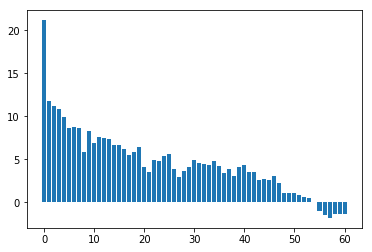

In [196]:
plt.bar(range(len(lr_gap_coefs)), lr_gap_coefs)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


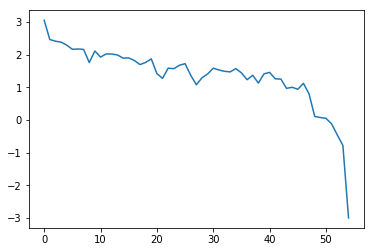

In [197]:
plt.plot(range(len(lr_gap_coefs)), np.log(lr_gap_coefs))

In [198]:
lr_gap_popularity_pred = lr_gap.predict(feature_gap_df[FEATURES])
lr_gap_popularity_truth = feature_gap_df['spotify_popularity_2018']
lr_gap_rmse = np.sqrt(sklearn.metrics.mean_squared_error(lr_gap_popularity_pred, lr_gap_popularity_truth))
print ("LR RMSE: {}".format(lr_gap_rmse))

LR RMSE: 16714.31036109551


In [199]:
analysis_model(lr_gap, 'LR_gap')

RMSE: 16714.31036109551
LR_gap Rank RMSE: 7137.524667359253
Top 10 Percision: 0.0, Recall: 0.0
Top 100 Percision: 0.24, Recall: 0.24
Top 200 Percision: 0.33, Recall: 0.33
Top 500 Percision: 0.314, Recall: 0.314
Top 1000 Percision: 0.349, Recall: 0.349


In [194]:
print (lr_gap_coefs - lr_coefs)

[-6.93889390e-18  1.38777878e-17  1.04083409e-16  3.46944695e-18
 -6.93889390e-18 -1.11022302e-16  6.93889390e-18  6.93889390e-17
  1.90819582e-17  5.55111512e-17  3.46944695e-17 -3.46944695e-18
  6.93889390e-18  1.63064007e-16 -1.04083409e-17  3.12250226e-17
  4.51028104e-17  5.20417043e-18  2.08166817e-17  6.93889390e-18
  0.00000000e+00  1.73472348e-17  4.51028104e-17  4.16333634e-17
  6.07153217e-17 -7.11236625e-17  5.03069808e-17  1.73472348e-18
  1.73472348e-17  8.15320034e-17  5.20417043e-17  4.51028104e-17
  1.73472348e-18  1.73472348e-17  2.77555756e-17  2.08166817e-17
  5.20417043e-18  2.77555756e-17  5.20417043e-18  1.90819582e-17
  3.98986399e-17  3.98986399e-17  3.12250226e-17  3.29597460e-17
  5.20417043e-17 -5.20417043e-18  1.56125113e-17 -3.46944695e-18
  1.47451495e-17  1.38777878e-17  2.25514052e-17  6.07153217e-18
  1.56125113e-17  2.77555756e-17  2.55871713e-17  1.90819582e-17
  1.38777878e-17 -5.20417043e-18 -6.93889390e-18  3.12250226e-17
 -3.81639165e-17]


In [226]:
import lightgbm as lgbm
def run_lgb(train_X, train_y, val_X, val_y, test_X, mode='train'):
    params = {
        "objective" : "regression",
        'nthread': 16,
        "num_leaves" : 200,
        "metric" : "rmse", 
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_seed" : 519,
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 100,
        'scale_pos_weight':1,
        "verbosity" : -1
    }
    
    lgtrain = lgbm.Dataset(train_X, label=train_y)
    lgval = lgbm.Dataset(val_X, label=val_y)
    model = lgbm.train(params, lgtrain, 250000, valid_sets=[lgval], early_stopping_rounds=1000, verbose_eval=2500)
    
#     if mode=='train':
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
#     pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
#     elif mode=='permutation':
#         pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
#         pred_test_y=0
    return model, pred_test_y

In [209]:
lgbm_gap_model, lgbm_gap_pred = run_lgb(feature_gap_df[FEATURES], feature_gap_df['spotify_popularity_2018'], 
                                       feature_gap_df[FEATURES], feature_gap_df['spotify_popularity_2018'], feature_gap_df[FEATURES])

Training until validation scores don't improve for 1000 rounds.
[2500]	valid_0's rmse: 13.0253
[5000]	valid_0's rmse: 12.3541
[7500]	valid_0's rmse: 11.9393
[10000]	valid_0's rmse: 11.6507
[12500]	valid_0's rmse: 11.4865
[15000]	valid_0's rmse: 11.4108
[17500]	valid_0's rmse: 11.3825
[20000]	valid_0's rmse: 11.3754
[22500]	valid_0's rmse: 11.3733
[25000]	valid_0's rmse: 11.3718
[27500]	valid_0's rmse: 11.3703
[30000]	valid_0's rmse: 11.3692
[32500]	valid_0's rmse: 11.3674
[35000]	valid_0's rmse: 11.3665
[37500]	valid_0's rmse: 11.3657
[40000]	valid_0's rmse: 11.3648
[42500]	valid_0's rmse: 11.3641
[45000]	valid_0's rmse: 11.3626
[47500]	valid_0's rmse: 11.362
[50000]	valid_0's rmse: 11.3613
[52500]	valid_0's rmse: 11.3608
[55000]	valid_0's rmse: 11.3603
[57500]	valid_0's rmse: 11.3598
[60000]	valid_0's rmse: 11.3594
Early stopping, best iteration is:
[60387]	valid_0's rmse: 11.3594


In [ ]:
analysis_model(lgbm_gap_pred, 'LGBM_gap')

RMSE: 11.359372151578517


In [227]:
lgbm_gap_52_model, lgbm_gap_52_pred = run_lgb(feature_gap_df[FEATURES]-52, feature_gap_df['spotify_popularity_2018'], 
                                       feature_gap_df[FEATURES]-52, feature_gap_df['spotify_popularity_2018'], feature_gap_df[FEATURES]-52)
analysis_model(lgbm_gap_52_pred, 'LGBM_gap_52')

Training until validation scores don't improve for 1000 rounds.
[2500]	valid_0's rmse: 13.1851
[5000]	valid_0's rmse: 12.6021
[7500]	valid_0's rmse: 12.2643
[10000]	valid_0's rmse: 12.0989
[12500]	valid_0's rmse: 12.0653
[15000]	valid_0's rmse: 12.0612
Early stopping, best iteration is:
[15127]	valid_0's rmse: 12.0609
RMSE: 12.060877539072775
LGBM_52 Rank RMSE: 4289.848914637458
Top 10 Percision: 0.0, Recall: 0.0
Top 100 Percision: 0.45, Recall: 0.45
Top 200 Percision: 0.54, Recall: 0.54
Top 500 Percision: 0.574, Recall: 0.574
Top 1000 Percision: 0.617, Recall: 0.617


In [228]:
lgbm_model, lgbm_pred = run_lgb(feature_df[FEATURES], feature_df['spotify_popularity_2018'], 
                                       feature_df[FEATURES], feature_df['spotify_popularity_2018'], feature_gap_df[FEATURES])
analysis_model(lgbm_pred, 'LGBM')

Training until validation scores don't improve for 1000 rounds.
[2500]	valid_0's rmse: 13.0215
[5000]	valid_0's rmse: 12.3503
[7500]	valid_0's rmse: 11.9351
[10000]	valid_0's rmse: 11.6517
[12500]	valid_0's rmse: 11.4886
[15000]	valid_0's rmse: 11.4142
[17500]	valid_0's rmse: 11.3869
[20000]	valid_0's rmse: 11.3798
[22500]	valid_0's rmse: 11.3772
[25000]	valid_0's rmse: 11.3757
[27500]	valid_0's rmse: 11.3741
[30000]	valid_0's rmse: 11.3725
[32500]	valid_0's rmse: 11.3707
[35000]	valid_0's rmse: 11.3698
[37500]	valid_0's rmse: 11.369
[40000]	valid_0's rmse: 11.3682
[42500]	valid_0's rmse: 11.3675
[45000]	valid_0's rmse: 11.3668
[47500]	valid_0's rmse: 11.3662
[50000]	valid_0's rmse: 11.3647
[52500]	valid_0's rmse: 11.3641
[55000]	valid_0's rmse: 11.3636
[57500]	valid_0's rmse: 11.3631
[60000]	valid_0's rmse: 11.3627
Early stopping, best iteration is:
[59620]	valid_0's rmse: 11.3627
RMSE: 11.362678651513164
LGBM Rank RMSE: 4003.4147541805314
Top 10 Percision: 0.0, Recall: 0.0
Top 100 Pe

In [236]:
lgbm_52_model, lgbm_52_pred = run_lgb(feature_df[FEATURES]-52, feature_df['spotify_popularity_2018'], 
                                       feature_df[FEATURES]-52, feature_df['spotify_popularity_2018'], feature_gap_df[FEATURES]-52)
analysis_model(lgbm_52_pred, 'LGBM')

Training until validation scores don't improve for 1000 rounds.
[2500]	valid_0's rmse: 13.1851
[5000]	valid_0's rmse: 12.6021
[7500]	valid_0's rmse: 12.2643
[10000]	valid_0's rmse: 12.0989
[12500]	valid_0's rmse: 12.0653
[15000]	valid_0's rmse: 12.0612
Early stopping, best iteration is:
[15127]	valid_0's rmse: 12.0609
RMSE: 12.060877539072775
LGBM Rank RMSE: 4289.848914637458
Top 10 Percision: 0.0, Recall: 0.0
Top 100 Percision: 0.45, Recall: 0.45
Top 200 Percision: 0.54, Recall: 0.54
Top 500 Percision: 0.574, Recall: 0.574
Top 1000 Percision: 0.617, Recall: 0.617


In [233]:
def run_classify_lgb(train_X, train_y, val_X, val_y, test_X, mode='train'):
    params = {
        "objective" : "multiclass",
        "num_class": 100,
        'nthread': 16,
        "num_leaves" : 200,
        "metric" : "multi_error", 
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_seed" : 519,
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 100,
        'scale_pos_weight':1,
        "verbosity" : -1
    }
    
    lgtrain = lgbm.Dataset(train_X, label=train_y)
    lgval = lgbm.Dataset(val_X, label=val_y)
    model = lgbm.train(params, lgtrain, 250000, valid_sets=[lgval], early_stopping_rounds=1000, verbose_eval=2500)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)

    return model, pred_test_y

In [234]:
lgbm_cl_model, lgbm_cl_pred = run_classify_lgb(feature_df[FEATURES], feature_df['spotify_popularity_2018'], 
                                       feature_df[FEATURES], feature_df['spotify_popularity_2018'], feature_gap_df[FEATURES])
analysis_model(lgbm_cl_pred, 'LGBM_cl')

Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[134]	valid_0's multi_error: 0.876017


ValueError: y_true and y_pred have different number of output (100!=1)

In [235]:
print (lgbm_cl_pred)

[[2.61575397e-02 6.23362739e-03 2.57667532e-03 ... 4.52188393e-04
  8.71889083e-18 8.71889085e-03]
 [5.31366240e-02 1.01610083e-02 1.85968680e-03 ... 3.83200820e-04
  7.38870382e-18 7.38870384e-03]
 [2.18432679e-02 5.75233771e-03 6.26825463e-03 ... 4.93669490e-04
  9.51871046e-18 9.51871049e-03]
 ...
 [5.27558696e-02 9.54617734e-03 1.33562986e-02 ... 4.91867690e-04
  9.48396897e-18 9.48396899e-03]
 [2.78943225e-02 1.77130270e-02 5.87171325e-03 ... 4.44022699e-04
  8.56144362e-18 8.56144364e-03]
 [1.65064990e-01 6.79685136e-02 1.73226597e-01 ... 2.52462860e-04
  4.86787397e-18 4.86787399e-03]]
